---
**Turma**: 15

**Grupo**: 11 - Bruno Correia, Gilson Costa, Vivian Liu

**Contato**: `brunovpm@hotmail.com, gilson.costa@gmail.com, liuoliveira.vivian@gmail.com`

**Licença deste notebook**:
![CC BY](https://licensebuttons.net/l/by/3.0/88x31.png)

[Clique aqui para saber mais sobre a licença CC BY v4.0](https://creativecommons.org/licenses/by/4.0/legalcode.pt)

### Objetivo:

 Quais seriam as outras abordagem para segmentação dos clientes do ifood?

### Etapas:

1) Carregar ABT (analytical base table) e importar tabelas

2) Seleção de variáveis

3) Tratamento de missing

4) Modelagem com K-means

5) Selecionando o K ótimo com o método Elbow e Silhoutte Score

6) Análise descritiva dos K clusters

### 1) Carregando Analytical base table

In [0]:
from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 

root_dir = '/dbfs/FileStore/ifood'
dbutils.fs.ls(f'{root_dir}')

df_abt_push_session_november = spark.read.parquet(f'{root_dir}/abt/push_session_november').repartition(2).cache()
print((df_abt_push_session_november.count(), len(df_abt_push_session_november.columns)))

(23920, 46)

### 2) Seleção de variáveis

In [0]:
features = [
#  'buyer',
#  'event_date',
 #'external_user_id',
#  'last_send_date',
#  'last_received_date',
#  'last_bounce_date',
#  'last_click_date',
#  'total_event_dawn',
#  'total_event_breakfast',
#  'total_event_lunch',
#  'total_event_snack',
#  'total_event_dinner',
#  'total_send_dawn',
#  'total_send_breakfast',
#  'total_send_lunch',
#  'total_send_snack',
#  'total_send_dinner',
#  'total_received_dawn',
#  'total_received_breakfast',
#  'total_received_lunch',
#  'total_received_snack',
#  'total_received_dinner',
#  'total_bounce_dawn',
#  'total_bounce_breakfast',
#  'total_bounce_lunch',
#  'total_bounce_snack',
#  'total_bounce_dinner',
#  'total_click_dawn',
#  'total_click_breakfast',
#  'total_click_lunch',
#  'total_click_snack',
#  'total_click_dinner',
 #'total_event',
 'total_send',
 #'total_received',
 # 'total_bounce',
 'total_click',
#  'session_date',
#  'user_identifier',
 'sum_event_open',
 'sum_view_restaurant_screen',
 'sum_view_dish_screen',
 'sum_click_add_item',
 'sum_view_checkout',
 'sum_callback_purchase',
 'order_session_quantity'
]

abt = df_abt_push_session_november[features]

In [0]:
abt.fillna(0)

Out[4]: DataFrame[total_send: bigint, total_click: bigint, sum_event_open: double, sum_view_restaurant_screen: double, sum_view_dish_screen: double, sum_click_add_item: double, sum_view_checkout: double, sum_callback_purchase: double, order_session_quantity: double]

#### Correlação entre as variáveis selecionadas

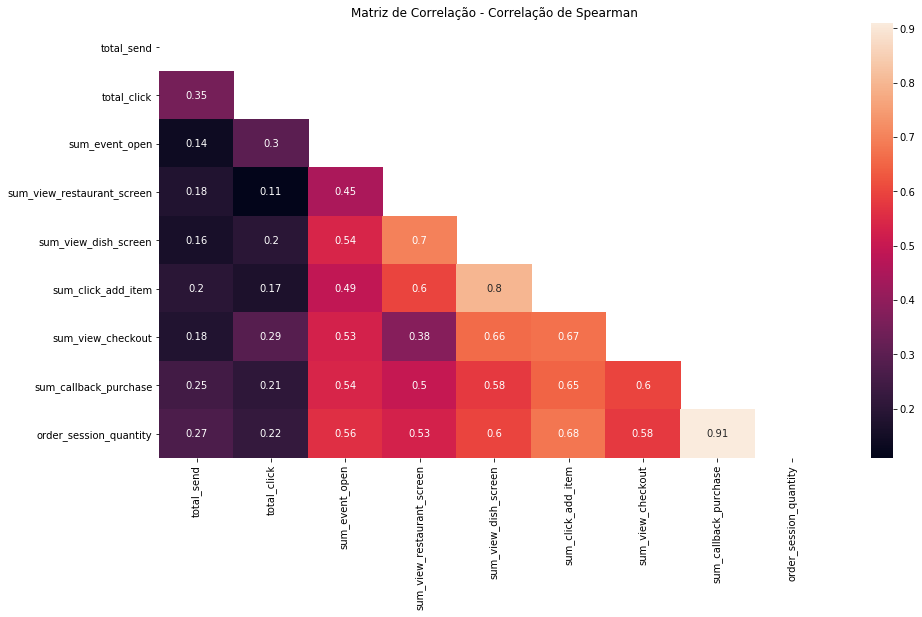

In [0]:
### Correlação

correlação = round(abt.toPandas().corr(method='spearman'), 2)
triangulo = correlação.where(np.tril(np.ones(correlação.shape), k=-1).astype(np.bool))

#Criando uma representação gráfica para a matriz de correlação
sns.heatmap(triangulo, 
            xticklabels=correlação.columns.values,
            yticklabels=correlação.columns.values,annot=True)

plt.title('Matriz de Correlação - Correlação de Spearman')
plt.gcf().set_size_inches(15,8)
plt.show()

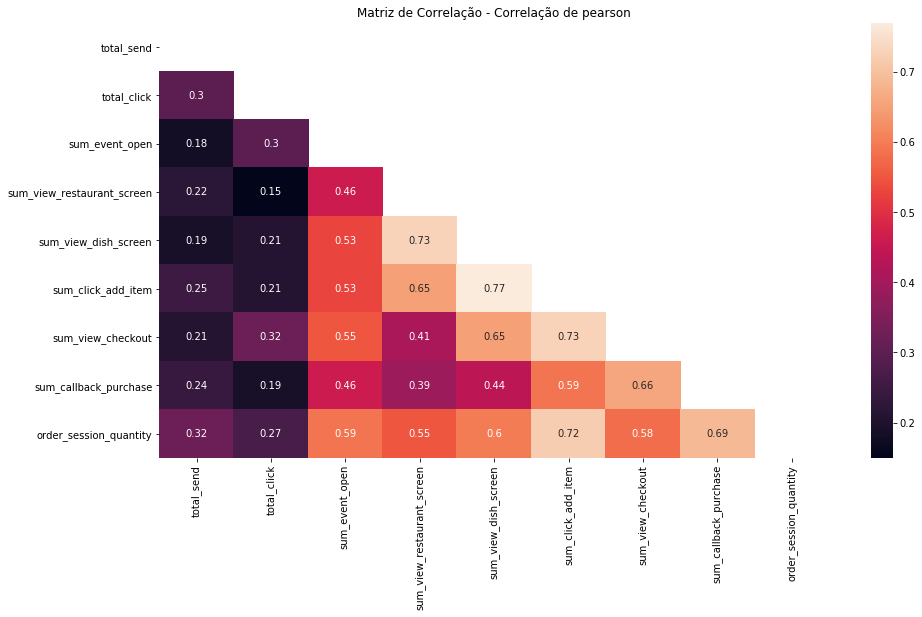

In [0]:
### Correlação

correlação = round(abt.toPandas().corr(method='pearson'), 2)
triangulo = correlação.where(np.tril(np.ones(correlação.shape), k=-1).astype(np.bool))

#Criando uma representação gráfica para a matriz de correlação
sns.heatmap(triangulo, 
            xticklabels=correlação.columns.values,
            yticklabels=correlação.columns.values,annot=True)

plt.title('Matriz de Correlação - Correlação de pearson')
plt.gcf().set_size_inches(15,8)
plt.show()

### 3) Tratamento de missing

In [0]:
abt.toPandas().isnull().sum().reset_index()

,index,0
0,total_send,0
1,total_click,0
2,sum_event_open,15751
3,sum_view_restaurant_screen,15751
4,sum_view_dish_screen,15751
5,sum_click_add_item,15751
6,sum_view_checkout,15751
7,sum_callback_purchase,15751
8,order_session_quantity,15751


In [0]:
df = abt.fillna(0)
df.toPandas().isnull().sum().reset_index()

,index,0
0,total_send,0
1,total_click,0
2,sum_event_open,0
3,sum_view_restaurant_screen,0
4,sum_view_dish_screen,0
5,sum_click_add_item,0
6,sum_view_checkout,0
7,sum_callback_purchase,0
8,order_session_quantity,0


### 4) Modelagem com K-means


- Criação do vector assembler
- Padronização das variáveis

##### Criando o vetor com as features (VectorAssembler)

In [0]:
df2 = VectorAssembler().setInputCols(features).setOutputCol('features').transform(df)      

##### Padronizando as variáveis

In [0]:
scaler = StandardScaler(inputCol= 'features', outputCol="scaledFeatures",withStd=True, withMean=False)
scalerModel = scaler.fit(df2)
scaledData = scalerModel.transform(df2)

#### Tratamento de outliers
_usamos o RobustScaler para tratar os outliers (percentil 1% e percentil 99%)_

In [0]:
# Rodas no spark 3.0
from pyspark.ml.feature import RobustScaler

scaler = RobustScaler(
  inputCol="features",
  outputCol="scaledFeatures",
  withScaling=True,
  withCentering=False,
  lower=0.01,
  upper=0.99
)

scalerModel = scaler.fit(df2)
scaledData = scalerModel.transform(df2)

### 5) Selecionando o K ótimo com o método Elbow e Silhoutte Score

In [0]:
#Elbow
n_clusters = []
custo = []

#Silhoutte score 
cost = list()
evaluator = ClusteringEvaluator()

for i in range(3, 8):
  kmedias = KMeans(featuresCol='scaledFeatures').setK(i).setSeed(42)
  modelo = kmedias.fit(scaledData)
  #Elbow
  n_clusters.append(i)
  custo.append(modelo.summary.trainingCost)
  
  #silhoutte score
  tags_predictions = modelo.transform(scaledData)
  silhouette = evaluator.evaluate(tags_predictions)
  cost.append(silhouette)

#### Método Elbow

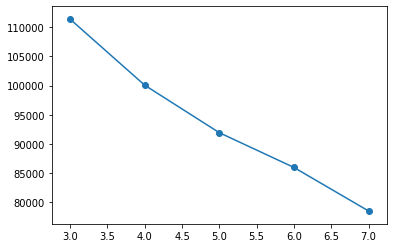

In [0]:
#n_clusters = []
#custo = []

#for i in range(3, 8):
 # kmedias = KMeans().setK(i).setSeed(42)
 # modelo = kmedias.fit(scaledData)
 # n_clusters.append(i)
  #custo.append(modelo.summary.trainingCost)
  
plt.plot(n_clusters, custo)
plt.scatter(n_clusters, custo)
display(plt.show())

#### Silhoutte scores

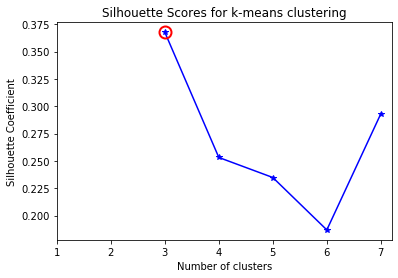

In [0]:
#from pyspark.ml.evaluation import ClusteringEvaluator
#cost = list()
#evaluator = ClusteringEvaluator()
#for i in range(3, 8):
#  kmedias = KMeans().setK(i).setSeed(42)
 # modelo = kmedias.fit(scaledData)
 # tags_predictions = modelo.transform(scaledData)
  #silhouette = evaluator.evaluate(tags_predictions)
  #cost.append(silhouette)

    
kIdx = np.argmax(cost)

fig, ax = plt.subplots()
plt.plot(range(3,8), cost, 'b*-')
plt.plot(range(3,8)[kIdx], cost[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Scores for k-means clustering')
# Uncomment the next line
display(fig)

#### K Means

In [0]:
best_k = 3

kmedias = KMeans(featuresCol='scaledFeatures').setK(best_k).setSeed(42)

modelo = kmedias.fit(scaledData)

predicoes = modelo.transform(scaledData)

In [0]:
pdPredicao = predicoes.toPandas()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:88: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
 Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
 warnings.warn(msg)

In [0]:
display(predicoes)

total_send,total_click,sum_event_open,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,order_session_quantity,features,scaledFeatures,prediction
42,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"List(0, 9, List(0, 1), List(42.0, 2.0))","List(0, 9, List(0, 1), List(1.1897050846595134, 0.43677711280755527))",0
19,0,3.0,37.0,15.0,5.0,6.0,1.0,1.0,"List(1, 9, List(), List(19.0, 0.0, 3.0, 37.0, 15.0, 5.0, 6.0, 1.0, 1.0))","List(1, 9, List(), List(0.5381999192507322, 0.0, 0.33770443202137246, 2.6998297532892512, 1.7874314003502563, 1.2029845991036194, 1.0171682592581097, 0.49233708849404945, 0.7972909520592446))",2
73,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"List(0, 9, List(0, 1), List(73.0, 1.0))","List(0, 9, List(0, 1), List(2.0678207423843924, 0.21838855640377763))",0
78,1,10.0,1.0,1.0,1.0,1.0,1.0,1.0,"List(1, 9, List(), List(78.0, 1.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))","List(1, 9, List(), List(2.2094523000819533, 0.21838855640377763, 1.1256814400712414, 0.0729683717105203, 0.11916209335668375, 0.24059691982072387, 0.16952804320968495, 0.49233708849404945, 0.7972909520592446))",0
74,4,34.0,8.0,8.0,5.0,14.0,3.0,3.0,"List(1, 9, List(), List(74.0, 4.0, 34.0, 8.0, 8.0, 5.0, 14.0, 3.0, 3.0))","List(1, 9, List(), List(2.0961470539239047, 0.8735542256151105, 3.827316896242221, 0.5837469736841624, 0.95329674685347, 1.2029845991036194, 2.3733926049355896, 1.4770112654821483, 2.391872856177734))",2
45,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"List(0, 9, List(0), List(45.0))","List(0, 9, List(0), List(1.27468401927805))",0
33,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"List(0, 9, List(0, 1), List(33.0, 8.0))","List(0, 9, List(0, 1), List(0.9347682808039034, 1.747108451230221))",0
62,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"List(0, 9, List(0), List(62.0))","List(0, 9, List(0), List(1.7562313154497577))",0
62,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"List(0, 9, List(0), List(62.0))","List(0, 9, List(0), List(1.7562313154497577))",0
50,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"List(0, 9, List(0), List(50.0))","List(0, 9, List(0), List(1.416315576975611))",0


#### Número de observações por cluster

In [0]:
predicaoCount = predicoes.groupby('prediction').count()
display(predicaoCount)
pdPredicaoCount = predicaoCount.toPandas().set_index('prediction')

prediction,count
1,662
2,4592
0,18666


### 6) Análise descritiva dos novos clusters

#### Cluster 0 - Só olhando (18666)
  - receberam push de marketing mas não realizaram nenhuma compra
  - média de 0.16 pedidos no mês
  - média de 55 envios de push por mês


#### Cluster 1 - Regulares (662)
  - Cliente que costumar realizar compras regularmente
  - média de 5 pedidos no mês
  - média de 106 envios por mês


#### Cluster 2 - Experimentou (4592)
  - Cliente que experimentaram o aplicativo e fizeram poucos pedidos
  - média de 2 pedidos no mês
  - média de 80 envios por mês

In [0]:
pd.set_option("display.precision", 4)

pdPredicaoSummary = predicoes.drop('features', 'scaledFeatures').toPandas()
pdPredicaoSummary = pdPredicaoSummary.groupby('prediction')[features].agg(['mean','median'])
pdPredicaoSummary.insert(0, 'count', pdPredicaoCount['count'])
pdPredicaoSummary.transpose()

prediction 
 0 
 1 
 2 
 
 
 
 
 count 
 
 18666.0000 
 662.0000 
 4592.0000 
 
 
 total_send 
 mean 
 55.8758 
 106.8912 
 80.1324 
 
 
 median 
 55.0000 
 104.0000 
 80.0000 
 
 
 total_click 
 mean 
 1.1924 
 9.3369 
 3.7981 
 
 
 median 
 0.0000 
 4.0000 
 2.0000 
 
 
 sum_event_open 
 mean 
 0.7113 
 34.1208 
 12.3386 
 
 
 median 
 0.0000 
 29.0000 
 10.0000 
 
 
 sum_view_restaurant_screen 
 mean 
 0.7276 
 55.2734 
 15.2726 
 
 
 median 
 0.0000 
 47.0000 
 11.0000 
 
 
 sum_view_dish_screen 
 mean 
 0.4824 
 36.1163 
 10.1640 
 
 
 median 
 0.0000 
 30.5000 
 9.0000 
 
 
 sum_click_add_item 
 mean 
 0.2862 
 18.2160 
 5.3336 
 
 
 median 
 0.0000 
 16.0000 
 5.0000 
 
 
 sum_view_checkout 
 mean 
 0.3781 
 22.9607 
 7.0324 
 
 
 median 
 0.0000 
 19.0000 
 6.0000 
 
 
 sum_callback_purchase 
 mean 
 0.1689 
 6.6873 
 2.2637 
 
 
 median 
 0.0000 
 5.0000 
 2.0000 
 
 
 order_session_quantity 
 mean 
 0.1582 
 5.1073 
 1.9754 
 
 
 median 
 0.0000 
 5.0000 
 2.0000

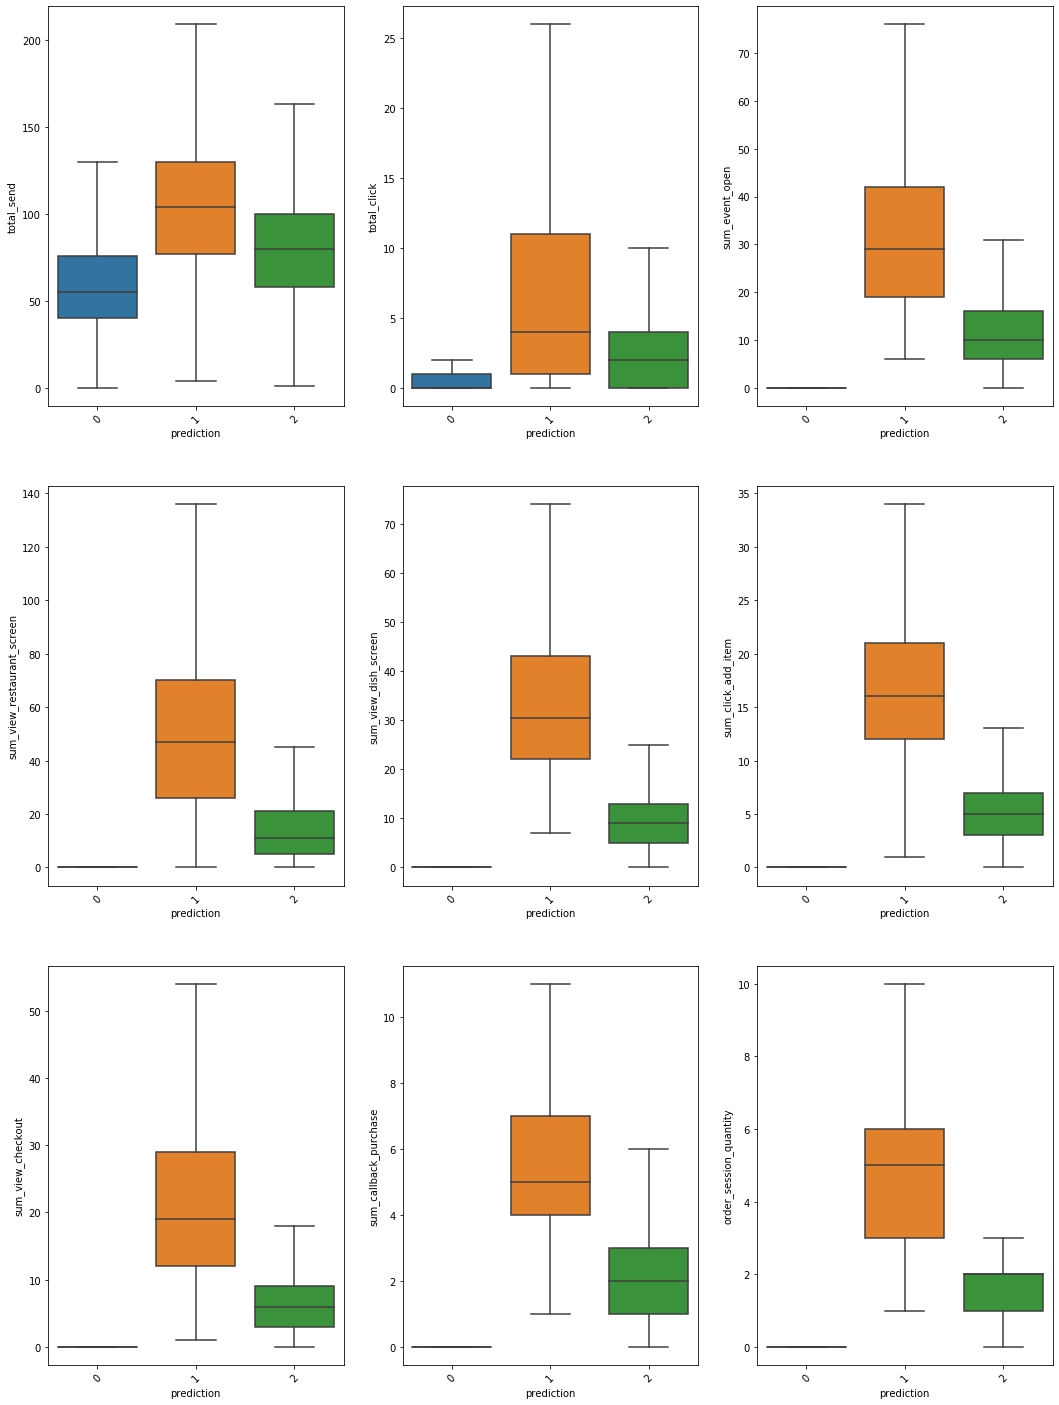

In [0]:
categorical = features

fig, ax = plt.subplots(len(categorical), 1, figsize=(18, 25))

for i, col in enumerate(categorical):
  plt.subplot(3, 3, i + 1)
  plt.xlabel(col, fontsize=10)
  plt.xticks(rotation=45)

  sns.boxplot(
    x='prediction',
    y = col,
    data=pdPredicao,
    dodge=False,
    showfliers=False,
    #order = ['1. Marlin', '2. Tilapia', '3. Subsidy Carp', '4. Retention Carp']
  )

plt.show()

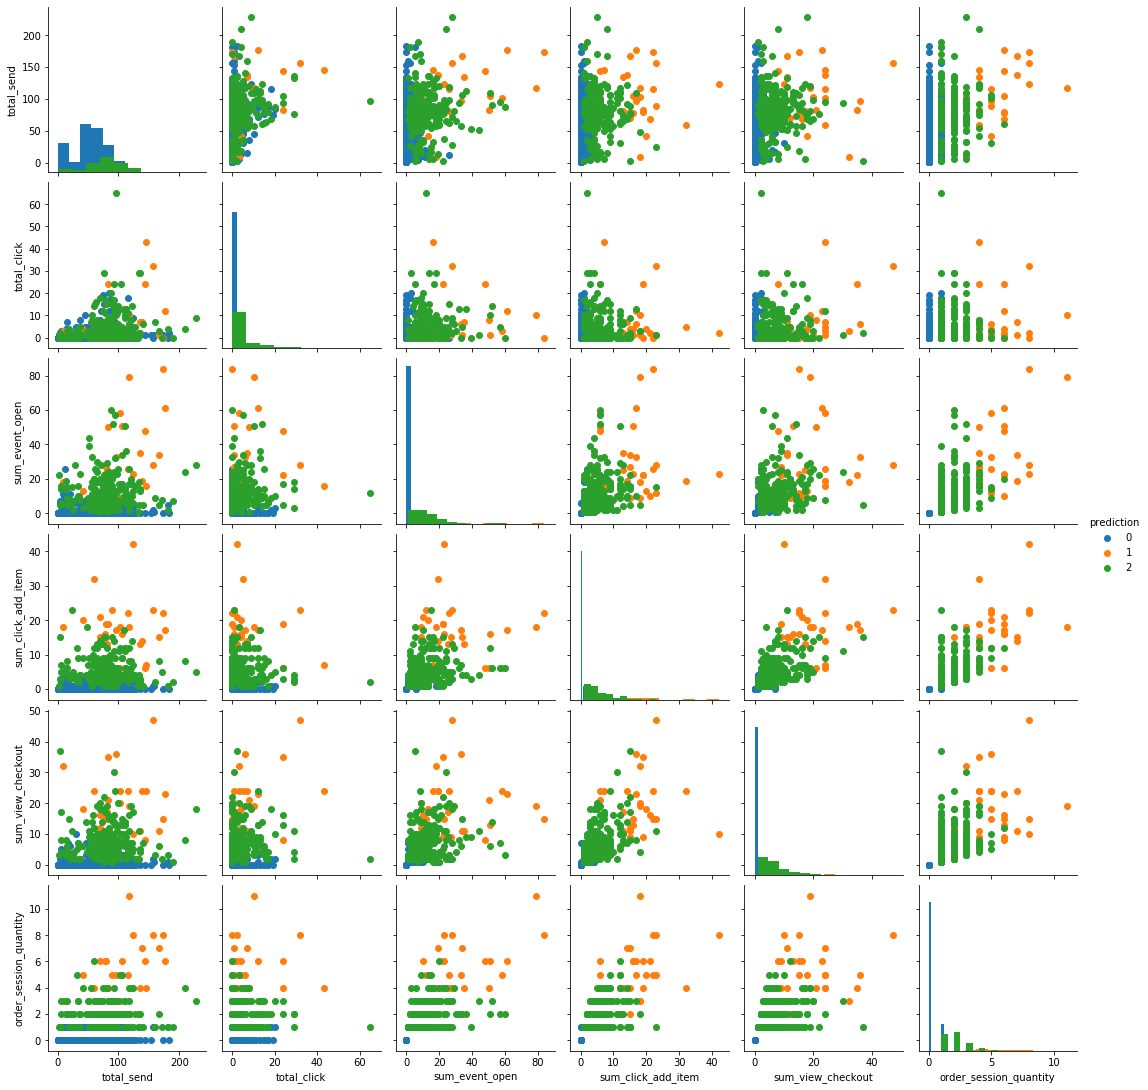

In [0]:
g = sns.PairGrid(
  pdPredicao[
      [
        'total_send',
        'total_click',
        'sum_event_open',
         'sum_click_add_item',
         'sum_view_checkout',
         'order_session_quantity',
        'prediction'
      ]
  ].sample(n=1000),
  hue="prediction"
)

g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

g.add_legend();


In [0]:
from pyspark.mllib.feature import PCA

pca = PCA()

In [0]:
import databricks.koalas as ks


--------------------------------------------------------------------------- 
 ModuleNotFoundError Traceback (most recent call last)
 <command-673658184209441> in <module> 
 ----> 1 import databricks . koalas as ks

 ModuleNotFoundError : No module named 'databricks'